<a href="https://colab.research.google.com/github/leelendhu/Video_editing/blob/main/Video_sort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import openCV library
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from numpy.core.numeric import Inf

#check the version of openCV (>4.1)
cv2.__version__

'4.1.2'

To input the video, you will have to mount the drive or upload locally. You will want to run the below cell to mount your google drive into the cloud VM so that you can access its contents. If you want to upload locally you can skip the next step.

NOTE: We will be creating a symbolic link between '/content/gdrive/My\ Drive/' and '/mydrive.

This means we are just creating a shortcut '/mydrive' to map to the contents within the folder '/content/gdrive/My\ Drive/'.

The reason for this is that sometime having the space in 'My Drive' folder path can cause issues when running certain commands. This symbolic link will stop this from happening

I recommend saving images within a folder called 'meero' at the root level of your Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


If you want to upload locally, you can do it on the left side under the files section. The current folder would be content by default and you can upload the file here.
In this case your videopath would be 'shuffled_19.mp4'

Now we convert the video into a set of frames and store it in an array called frame_array.
The input of the video is from the symbolic link to MyDrive.

In [2]:
def frames_from_video(video_path):
   '''An array of the frames from given video is returned 
    and the frames are saved''' 
   vid=cv2.VideoCapture(video_path)
   i=0
   frame_array = []
   while(vid.isOpened()):
      ret, frame = vid.read()
      if ret == False:
          break
      frame_array.append(frame)
      i+=1
   number_of_frames  = i
   vid.release()
   return frame_array  

In [6]:
videopath = '/content/gdrive/MyDrive/meero/shuffled_19.mp4'

#uncomment the below videopath if mounting locally in content folder
videopath = 'shuffled_19.mp4'
frame_array = frames_from_video(videopath)

We store the images in the frame array. We can find the total number of frames by calling the length of the frame array.

In [7]:
print(len(frame_array))

130


We have 130 frames, from 0 to 129. We can check how each frame looks using the cv2_imshow function

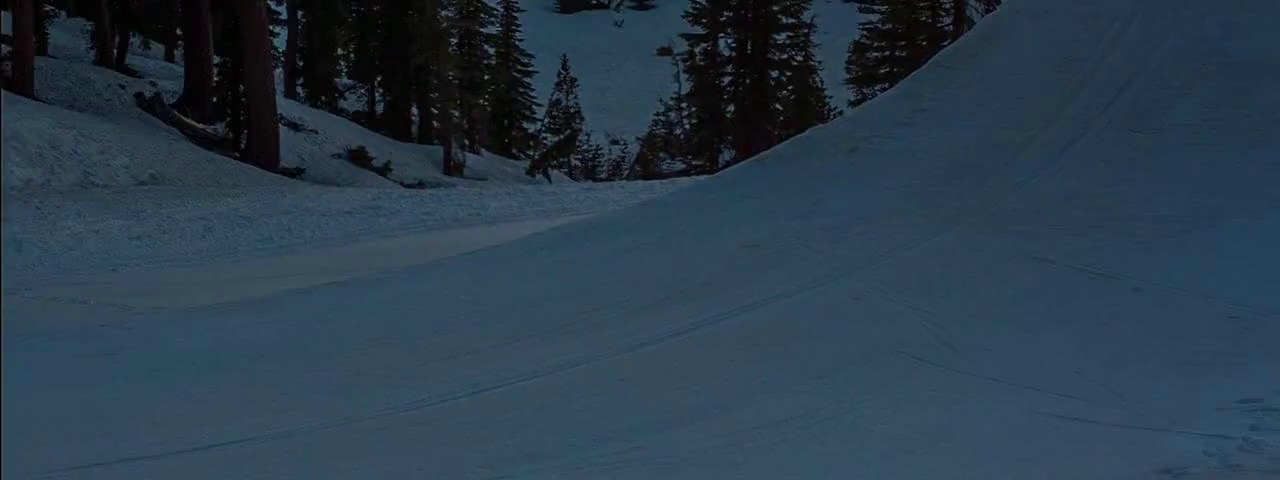

In [8]:
# Using cv2_imshow() method 
# Displaying the image  of frame 5
img = frame_array[4]
cv2_imshow(img)

Now we will create an array called averageL1. This array contains the average L1 norm between the image and its 5 closest neighbours. The idea behind this operation is that the L1 norm between two very similar images would be very low and between two vastly different images would be very high. Since in a video, consequent frames will mostly have very similar images, their L1 norms with their neighbours will be low. While the outliers will have high L1 norms with any other image. By finding the average L1 norm between the image and its 5 closest neighbours, we can easily detect the outliers.

In [9]:
def average_L1(frame_array):
    '''An array containing the average L1 norm of 5 nearest 
    neighbours for each image is returned'''
    averageL1 = list([])
    for i in frame_array:
        L1values = list([])
        for j in frame_array:
            L1 = cv2.norm( i, j, cv2.NORM_L1); 
            L1values.append(L1)
        L1values = np.sort(L1values)
        avg = sum(L1values[1:5])/5
        averageL1.append(avg)
    return averageL1

In [10]:
averageL1 = average_L1(frame_array)

There will be a big gap between the average L1 value of actual video frames and outliers. So we can sort our averageL1 array in ascending order calculate the biggest jump and use that as the distinction between outliers and wanted images, i.e the ones to the right of the biggest jump would be outliers and the ones to the left of the biggest jump would be our video frames.  We can then use that threshold value to remove the outliers. Let us call the new array without any outliers as corrected_array

In [11]:
def remove_outliers(averageL1, frame_array):
    '''Sorts the input array in ascending order and finds the biggest jump 
    between two consecutive values and removes all elements to the right of this 
     biggest jump'''
    averageL1sort = np.sort(averageL1)
    biggestjump = 0
    index_of_biggestjump = 0
    for i in range(len(averageL1sort) - 1):
        jump = averageL1sort[i+1] - averageL1sort[i]
        if jump > biggestjump:
            biggestjump = jump
            index_of_biggestjump = i

    corrected_list = list([])
    threshold = averageL1sort[index_of_biggestjump]
    for i in range(len(averageL1sort)):
        if averageL1[i]<=threshold:
            corrected_list.append(i)      

    corrected_array = []
    for i in corrected_list:
        frame = frame_array[i]
        corrected_array.append(frame)

    return corrected_array


In [12]:
corrected_array = remove_outliers(averageL1, frame_array)

We sort the corrected array based on the L1 values. We take the initial frame and find its L1 values with respect to all other images in the corrected array. The image which corresponds to the lowest L1 value will be our second frame. Again we find the corresponding image which will have the lowest L1 value from the remaining images. We will do this untill all the frames are sorted in order and return this sorted array

In [13]:
def sort_L1(array):
  '''Sorts an image array taking the first element as pivot and finding
  the closest L1 neighbour for it and repeating the same '''
  i = 0
  sorted = []
  sorted.append(array[i])
  array.pop(i)

  while len(array) > 1:
    nf = Inf
    ind1 = 0
    ind2 = 0
    for j in range(len(array)):
      img1 = sorted[i]
      img2 = array[j]
      d = cv2.norm(img1, img2, cv2.NORM_L1)
      if d < nf:
        nf = d
        ind1 = j
    sorted.append(array[ind1])
    array.pop(ind1)
    i = i+1
  sorted.append(array[0])
  return sorted


In [14]:
sortedL1 = sort_L1(corrected_array)

We will stitch the images in the sorted array to get our video. Unfortunately, google collab cannot run videos, so download the video.mp4 file from the Frames folder and run it. We see that the outliers have been removed.

In [15]:
def stitch_video(sorted_array, vid_output):
    '''Stores a mp4 file at the give path stitched from the 
    images in input array'''
    img=[]
    for i in sorted_array:
        img.append(i)
    height,width,layers=img[0].shape
    video_fin=cv2.VideoWriter(vid_output,cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),15,(width,height))
    for j in range(len(sorted_array)):
        video_fin.write(img[j])
    cv2.destroyAllWindows()
    video_fin.release()

In [17]:
vidpath = 'unjumbled.mp4'
stitch_video(sortedL1,vidpath)

If everything was done perfectly we would get this [video](https://drive.google.com/file/d/11JDP9zyCrllrJEZXGBvlJmLqDXp1EMSG/view?usp=sharing).



Clearly we see that the video is very smooth but reversed. It is quite interesting to note that unless we explicitly mention the exact initial frame the video can be either forwards or reversed. This is because our code doesnt have an understanding of what is happening in the video, it only tries to sort the frames based on the closest L1 neighbhour. 

Here we were lucky that the first frame of the sorted array happened to be the last frames of actual video. In case the first frame of the sorted array would have been the first frame of the actual video, we would get the video in forward direction. However in case we want to find the first or the last frame of the actual video, we can take the frame with the highest L1 average as our first frame

We can also use other methods of calculating distance between two images. These could be L2 norm, MSE, SSIM etc. Since all these three are using squares of the difference, their time complexity is higher and takes more time to compute. I have also explored feature matching, but without having any context about the video feature matching is a bad idea. Especially when outliers are not removed, we had observed that features between outiers and actual video frames were matched quite highly , even more than between actual video frames. We can also use the concept of siamese networks and triplet loss to train a deep network that calculates distance between two images. The main problem with such a solution is the training of data. If we have no context about input video, we will not be able to get a meaningful result.